In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

In [2]:
# Load data
df = pd.read_csv("ncaa_data_all.csv")

# Drop unneeded columns
X = df.drop(columns=["TeamID", "TeamName", "Ranking", "Quadrant"])
y = df["Quadrant"] - 1
team_names = df["TeamName"]  # Save TeamName separately

# Save indices to align names later
indices = np.arange(len(df))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split: train (64%), val (16%), test (20%)
X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=16)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16)


In [3]:
# Define model
class NCAA_Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NCAA_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

Epoch 1: Train Loss = 6.9847, Val Loss = 2.6629
Epoch 2: Train Loss = 1.6530, Val Loss = 1.4407
Epoch 3: Train Loss = 1.3943, Val Loss = 1.4163
Epoch 4: Train Loss = 1.2020, Val Loss = 1.2625
Epoch 5: Train Loss = 1.0899, Val Loss = 1.1783
Epoch 6: Train Loss = 1.1338, Val Loss = 1.5200
Epoch 7: Train Loss = 1.0500, Val Loss = 1.3641
Epoch 8: Train Loss = 1.1319, Val Loss = 1.1060
Epoch 9: Train Loss = 1.0056, Val Loss = 1.1373
Epoch 10: Train Loss = 1.0463, Val Loss = 1.0375
Epoch 11: Train Loss = 0.9702, Val Loss = 1.1120
Epoch 12: Train Loss = 0.9693, Val Loss = 1.2507
Epoch 13: Train Loss = 1.0435, Val Loss = 1.1146
Epoch 14: Train Loss = 0.9736, Val Loss = 1.0705
Epoch 15: Train Loss = 1.0383, Val Loss = 1.0641
Epoch 16: Train Loss = 0.9808, Val Loss = 1.0979
Epoch 17: Train Loss = 0.9099, Val Loss = 1.0279
Epoch 18: Train Loss = 0.9006, Val Loss = 1.0402
Epoch 19: Train Loss = 0.9525, Val Loss = 1.0906
Epoch 20: Train Loss = 1.0676, Val Loss = 1.0617
Epoch 21: Train Loss = 0.9401

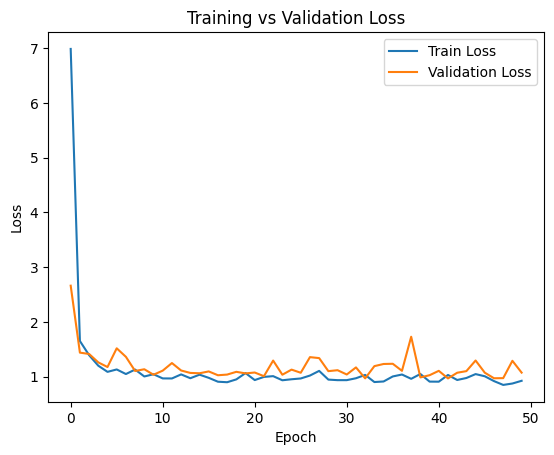

In [4]:

model = NCAA_Net(input_size=X.shape[1], num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation + checkpointing
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(50):
    # Training
    model.train()
    running_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            val_loss += criterion(val_outputs, val_y).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_ncaa_model.pt")

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

# Plot train vs val loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Confusion Matrix:


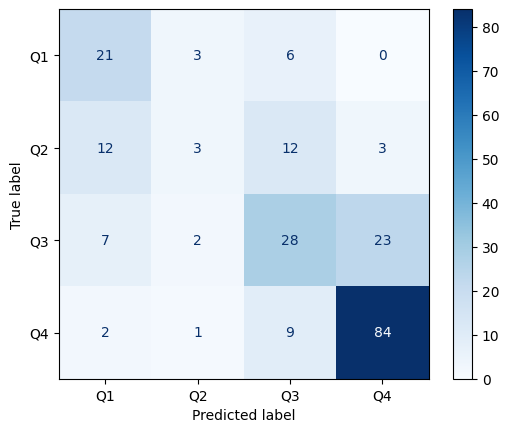

Weighted F1 Score: 0.6001


In [5]:


# Load best model and evaluate
model.load_state_dict(torch.load("best_ncaa_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Q1", "Q2", "Q3", "Q4"])
disp.plot(cmap='Blues')
plt.show()

print(f"Weighted F1 Score: {f1:.4f}")


Confusion Matrix:


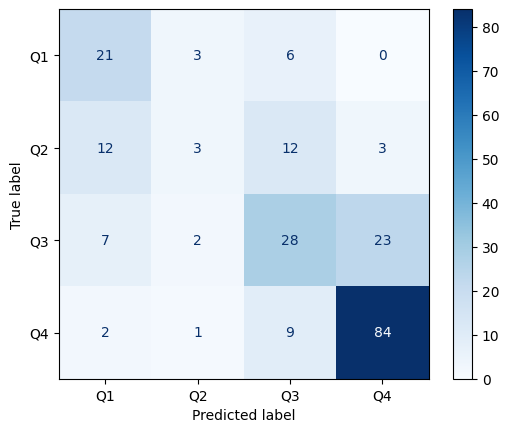

Weighted F1 Score: 0.6001
Saved test predictions with team names to 'ncaa_test_predictions_with_probs.csv'


In [6]:
# Load best model
model.load_state_dict(torch.load("best_ncaa_model.pt"))
model.eval()

all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        probs = softmax(logits, dim=1)  # Convert logits to probabilities
        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs.numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation metrics
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# Show confusion matrix
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Q1", "Q2", "Q3", "Q4"])
disp.plot(cmap='Blues')
plt.show()

print(f"Weighted F1 Score: {f1:.4f}")

# --- Export predictions with probabilities ---
test_team_names = team_names.iloc[idx_test].reset_index(drop=True)

results_df = pd.DataFrame(all_probs, columns=["P_Q1", "P_Q2", "P_Q3", "P_Q4"])
results_df["TeamName"] = test_team_names
results_df["True_Label"] = [f"Q{label+1}" for label in all_labels]
results_df["Pred_Label"] = [f"Q{pred+1}" for pred in all_preds]

# Reorder for readability
results_df = results_df[["TeamName", "True_Label", "Pred_Label", "P_Q1", "P_Q2", "P_Q3", "P_Q4"]]
results_df.to_csv("ncaa_test_predictions_with_probs.csv", index=False)

print("Saved test predictions with team names to 'ncaa_test_predictions_with_probs.csv'")

In [11]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Load your data
df = pd.read_csv("select_sun_stats2025.csv")

# 2) Pull off the team names
team_names = df["TeamName"]           # pandas Series, length N

# 3) Drop ID + name before modeling
X_df = df.drop(columns=["TeamID", "TeamName"])
X = X_df.values                       # numpy array of shape (N, D)
print("X shape:", X.shape)            # e.g. (363, 47)

# 4) Decide on device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 5) Wrap your feature array in a DataLoader (keep tensor on CPU)
X_tensor_cpu = torch.tensor(X, dtype=torch.float32)      # stays on CPU
loader = DataLoader(TensorDataset(X_tensor_cpu), batch_size=64, shuffle=False)

# 6) Run through your trained model, moving each batch to device
all_probs, all_preds = [], []

with torch.no_grad():
    for (xb_cpu,) in loader:
        xb = xb_cpu.to(device)                             # move inputs to same device as model
        logits = model(xb)                                 # now both xb & model on `device`
        probs = torch.softmax(logits, dim=1).cpu().numpy() # bring probs back to CPU
        preds = probs.argmax(axis=1)

        all_probs.append(probs)
        all_preds.append(preds)

# 7) Stack into arrays
all_probs = np.vstack(all_probs)   # shape (N, 4) if 4 quadrants
all_preds = np.concatenate(all_preds)

# 8) Build your final DataFrame including team names
prob_cols = ["P_Q1", "P_Q2", "P_Q3", "P_Q4"]
out = pd.DataFrame(all_probs, columns=prob_cols)
out["Pred_Label"] = [f"Q{pred+1}" for pred in all_preds]
out["TeamName"]  = team_names.values
out = out[["TeamName", "Pred_Label"] + prob_cols]

out


X shape: (364, 16)


,TeamName,Pred_Label,P_Q1,P_Q2,P_Q3,P_Q4
0,Duke,Q1,0.952396,0.040528,0.007034,0.000042
1,Houston,Q1,0.917896,0.056825,0.025137,0.000142
2,St_John's,Q1,0.782085,0.178582,0.038788,0.000546
3,Florida,Q1,0.949124,0.037495,0.013272,0.000109
4,Memphis,Q1,0.934044,0.038839,0.026922,0.000195
...,...,...,...,...,...,...
359,Bellarmine,Q4,0.000007,0.000591,0.017222,0.982180
360,Canisius,Q4,0.000019,0.000619,0.022161,0.977201
361,MD_E_Shore,Q4,0.000071,0.002026,0.063664,0.934239
362,Citadel,Q4,0.000045,0.001936,0.031073,0.966947


In [13]:
out.to_csv("2025_predicted_quadrants_M.csv", index=False)